# Helpful notes and general measurement tips

- **Spectrum Analyzer:** The spectrum analyzer tends to timeout if it hasn't been used in a while. To restart it, simply execute the qubit initialization again or use the qb._instrument.set() command to send a value and wake the instrument back up.
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
from qubit import qubit
import numpy as np
import plot_functions as pf
from helper_functions import load_data
# from instrument_init import init_sa

# Initialize qubit

In [59]:
qb = qubit('DARPA3A-Q3')

Loading parameter JSON file
2024-04-15 18:24:06,306 - qm - INFO     - Performing health check
2024-04-15 18:24:06,318 - qm - INFO     - Health check passed
Loading instrument settings from experiments\test\test_instruments.json.
Initializing readout_LO (BNC 845 Signal Generator).
Initializing qubit_LO (SignalCore SC5506A Signal Generator).
Initializing DA (Vaunix Lab Brick Digital Attenuator).
Initializing sa (SignalHound SpectrumAnalyzer).
Setting readout_LO frequency to 7600000000.0.
Setting readout_LO output to True.
Setting qubit_LO frequency to 4480000000.
Setting qubit_LO power to 17.
Setting qubit_LO output to True.
Setting DA attenuation to 20.


# Time of flight

Updating readout_atten to 0
Setting DA attenuation to 0.
Updating n_avg to 1000
Updating rr_IF to 5000000.0
Updating readout_length to 2000
2024-04-15 11:46:56,746 - qm - INFO     - Performing health check
2024-04-15 11:46:56,757 - qm - INFO     - Health check passed
2024-04-15 11:46:56,964 - qm - INFO     - Sending program to QOP for compilation
2024-04-15 11:46:57,136 - qm - INFO     - Executing program
Input 1 Offset: 0.1065898014948917 mV
Input 2 Offset: -0.11452836256760805 mV
Updating analog_input_offsets to [-0.05544683788345893, -0.05208169978709353]


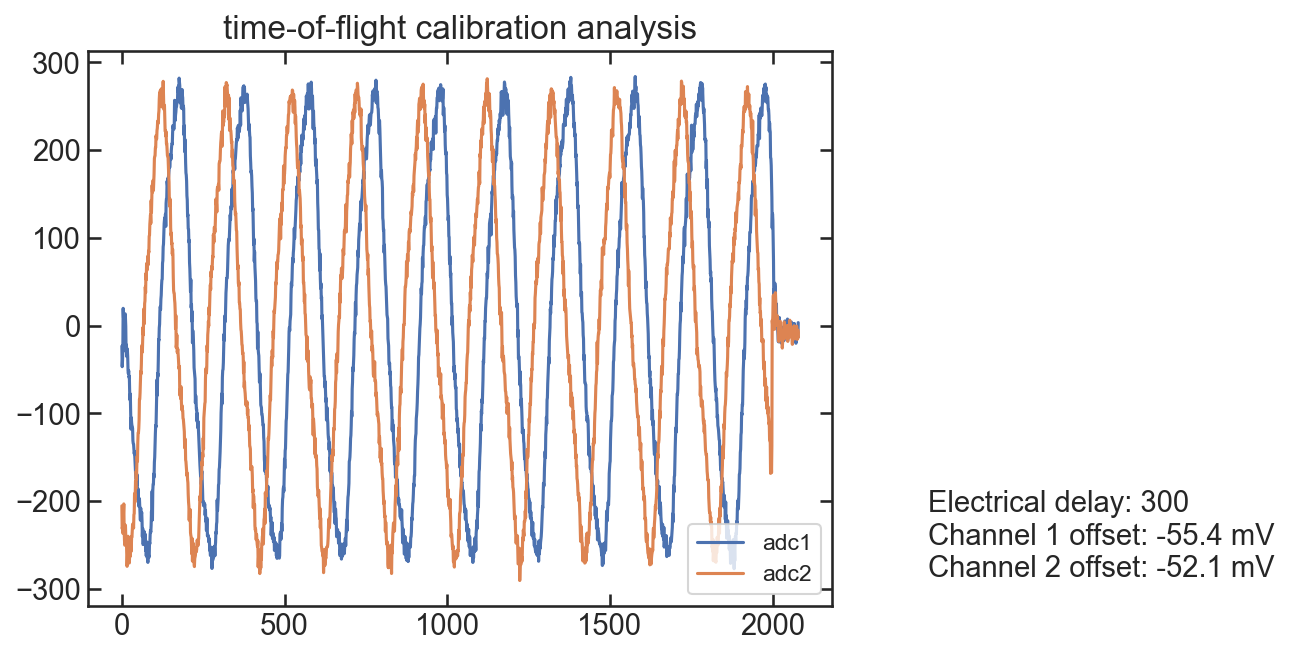

In [21]:
qb.update_value('readout_atten',0)
# qb.update_value('tof',240)
# qb.update_value('smearing',10)
qb.pars['resettime']['rr'] = 6000
qb.write_pars()
qb.update_value('n_avg',1000)
qb.update_value('rr_IF',5e6)
qb.update_value('readout_length',2000)

adc1,adc2 = qb.tof_cal(update_tof=False)
pf.tof_plot(adc1, adc2,delay=qb.pars['tof'],offsets=qb.pars['analog_input_offsets'])

# Optimize Mixers

## Minimize LO leakage 

Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 7600000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.
LO at 7.6 GHz
Current I_offset = -5.0 mV, Current Q_offset = 3.0 mV
Setting sa frequency to 7600000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -58.04785919189453.
Setting sa bandwidth to 1000.0.


100%|██████████| 121/121 [00:13<00:00,  9.17it/s]


Updating rr_mixer_offsets to [-0.0091, 0.0029000000000000007]
optimal I_offset = -9.1 mV, optimal Q_offset = 2.9 mV
Updating readout_atten to 0
Setting DA attenuation to 0.
Power: -95.830078125 dBm at 7.6 GHz


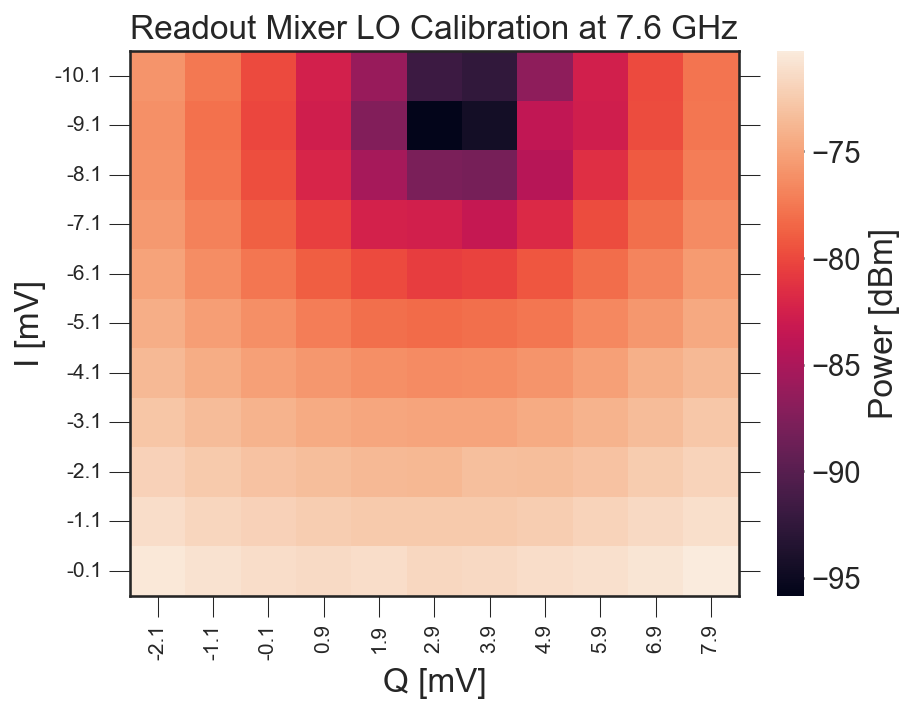

In [25]:
# qb.update_value('rr_LO',6.4e9)
# qb.get_power(fc=qb.pars['rr_LO'],threshold=-20,span=1e6,config=True,plot=True)
qb.opt_lo_leakage(mode='coarse',element='rr',sa_span=0.5e6,threshold=-20,plot=True)

In [ ]:
qb.opt_lo_leakage(mode='fine',element='rr',sa_span=0.5e6,threshold=-50,plot=True)

## Minimize image sideband

2024-04-15 12:03:01,254 - qm - INFO     - Sending program to QOP for compilation
2024-04-15 12:03:01,368 - qm - INFO     - Executing program
Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 7595000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.


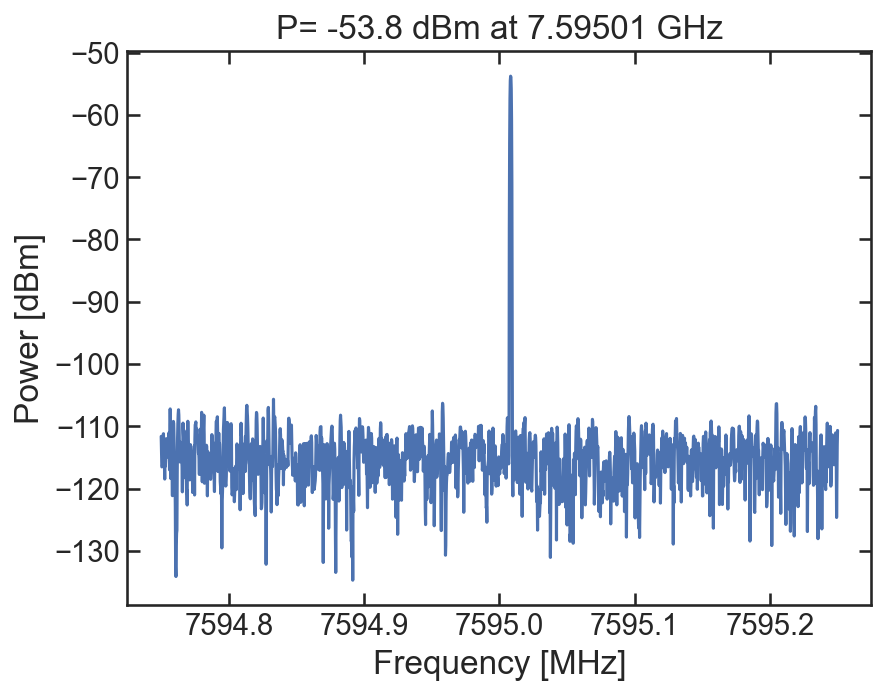

-53.78871536254883 dBm at 7.595008229589176 GHz
Sideband at 7.595 GHz
Current gain = 0, Current phase = 0


100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


Updating rr_mixer_imbalance to (0.011111111111111113, -0.08333333333333334)
optimal gain = 0.0111, optimal phi = -0.0833
Updating readout_atten to 0
Setting DA attenuation to 0.
Power: -53.89033126831055 dBm at 7.595 GHz


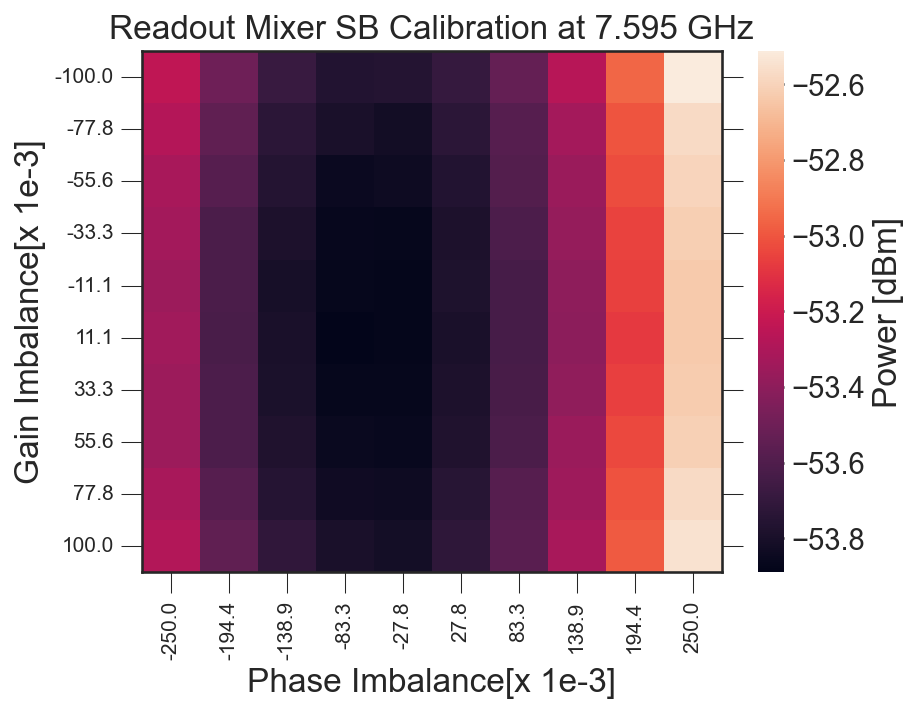

In [26]:
# qb.update_value('rr_IF',50e6)
qb.opt_sideband(mode='coarse',element='rr',sa_span=0.5e6,threshold=-20,plot=True)

In [ ]:
qb.opt_sideband(mode='fine',element='rr',sa_span=0.5e6,threshold=-50,plot=True)

# Resonator spectroscopy

**Notes on resonator spectroscopy**

In [76]:
qb.update_value('readout_length', 1000)   ##wanted a clearer peak
# qb.update_value('tof',256)
# qb.update_value('smearing',60)
# qb.update_value('rr_resettime',8000)
# qb.pars['resettime']['rr'] = 2000|
qb.write_pars()
qb.update_value('n_avg',100)
qb.update_value('readout_atten',20)
df_resonator_spec = 0.5e6
qb.experiment = 'resonator_spec'
##added a 10db fixed attenuator on rr line after the spiltter and just before fridge input
data, job = qb.resonator_spec(
                       f_LO = 7.6e9,
                       IF_min = 100e6,
                       IF_max = 170e6,
                       df = df_resonator_spec,
                       fit=True,
                       on_off=False,
                       savedata=True,
                       showprogress=True)

Updating readout_length to 1000
Updating n_avg to 100
Updating readout_atten to 20
Setting DA attenuation to 20.
Updating rr_LO to 7600000000.0
Setting readout_LO frequency to 7600000000.0.
2024-04-15 18:52:23,842 - qm - INFO     - Performing health check
2024-04-15 18:52:23,855 - qm - INFO     - Health check passed
2024-04-15 18:52:23,978 - qm - INFO     - Sending program to QOP for compilation
2024-04-15 18:52:24,101 - qm - INFO     - Executing program


 99%|█████████▉| 99/100 [00:00<00:00, 223.57it/s]


Saving data to G:\Shared drives\CavityCooling\DARPA\data\DARPA3A-Q3\resonator_spec\rr


In [79]:
load_data(directory=qb._directory,experiment=qb.experiment,iteration=1,element='rr')

({'elements': ['qubit', 'rr'],
  'qubit_LO': 4480000000,
  'rr_LO': 7600000000.0,
  'readout_atten': 20,
  'host': None,
  'port': '9510',
  'Iout': {'qubit': 3, 'rr': 1},
  'Qout': {'qubit': 4, 'rr': 2},
  'Iin': 1,
  'Qin': 2,
  'AWG_trigger_out': 1,
  'controller': 'con2',
  'n_avg': 100,
  'rr_IF': 5000000.0,
  'qubit_IF': 50000000.0,
  'gauss_len': 48,
  'gauss_amp': 0.45,
  'amp_r': 0.375,
  'readout_pulse_len_in_clk': 500,
  'saturation_duration': 2500,
  'readout_length': 1000,
  'qubit_freq': 4512900000,
  'rr_freq': 6200000000,
  'analog_input_offsets': [-0.05544683788345893, -0.05208169978709353],
  'analog_input_gain': 3,
  'rr_mixer_offsets': [-0.0091, 0.0029000000000000007],
  'qubit_mixer_offsets': [0, 0],
  'rr_mixer_imbalance': [0.011111111111111113, -0.08333333333333334],
  'qubit_mixer_imbalance': [0, 0],
  'tof': 256,
  'smearing': 40,
  'IQ_rotation': 0.0,
  'switch_weights': False,
  'resettime': {'qubit': 25000, 'rr': 6000},
  'kappa': 200000.0,
  'readout_freq':

Resonant Frequency: 7.72250 GHz
FWHM = 1.5 MHz
kappa = 9.425 MHz


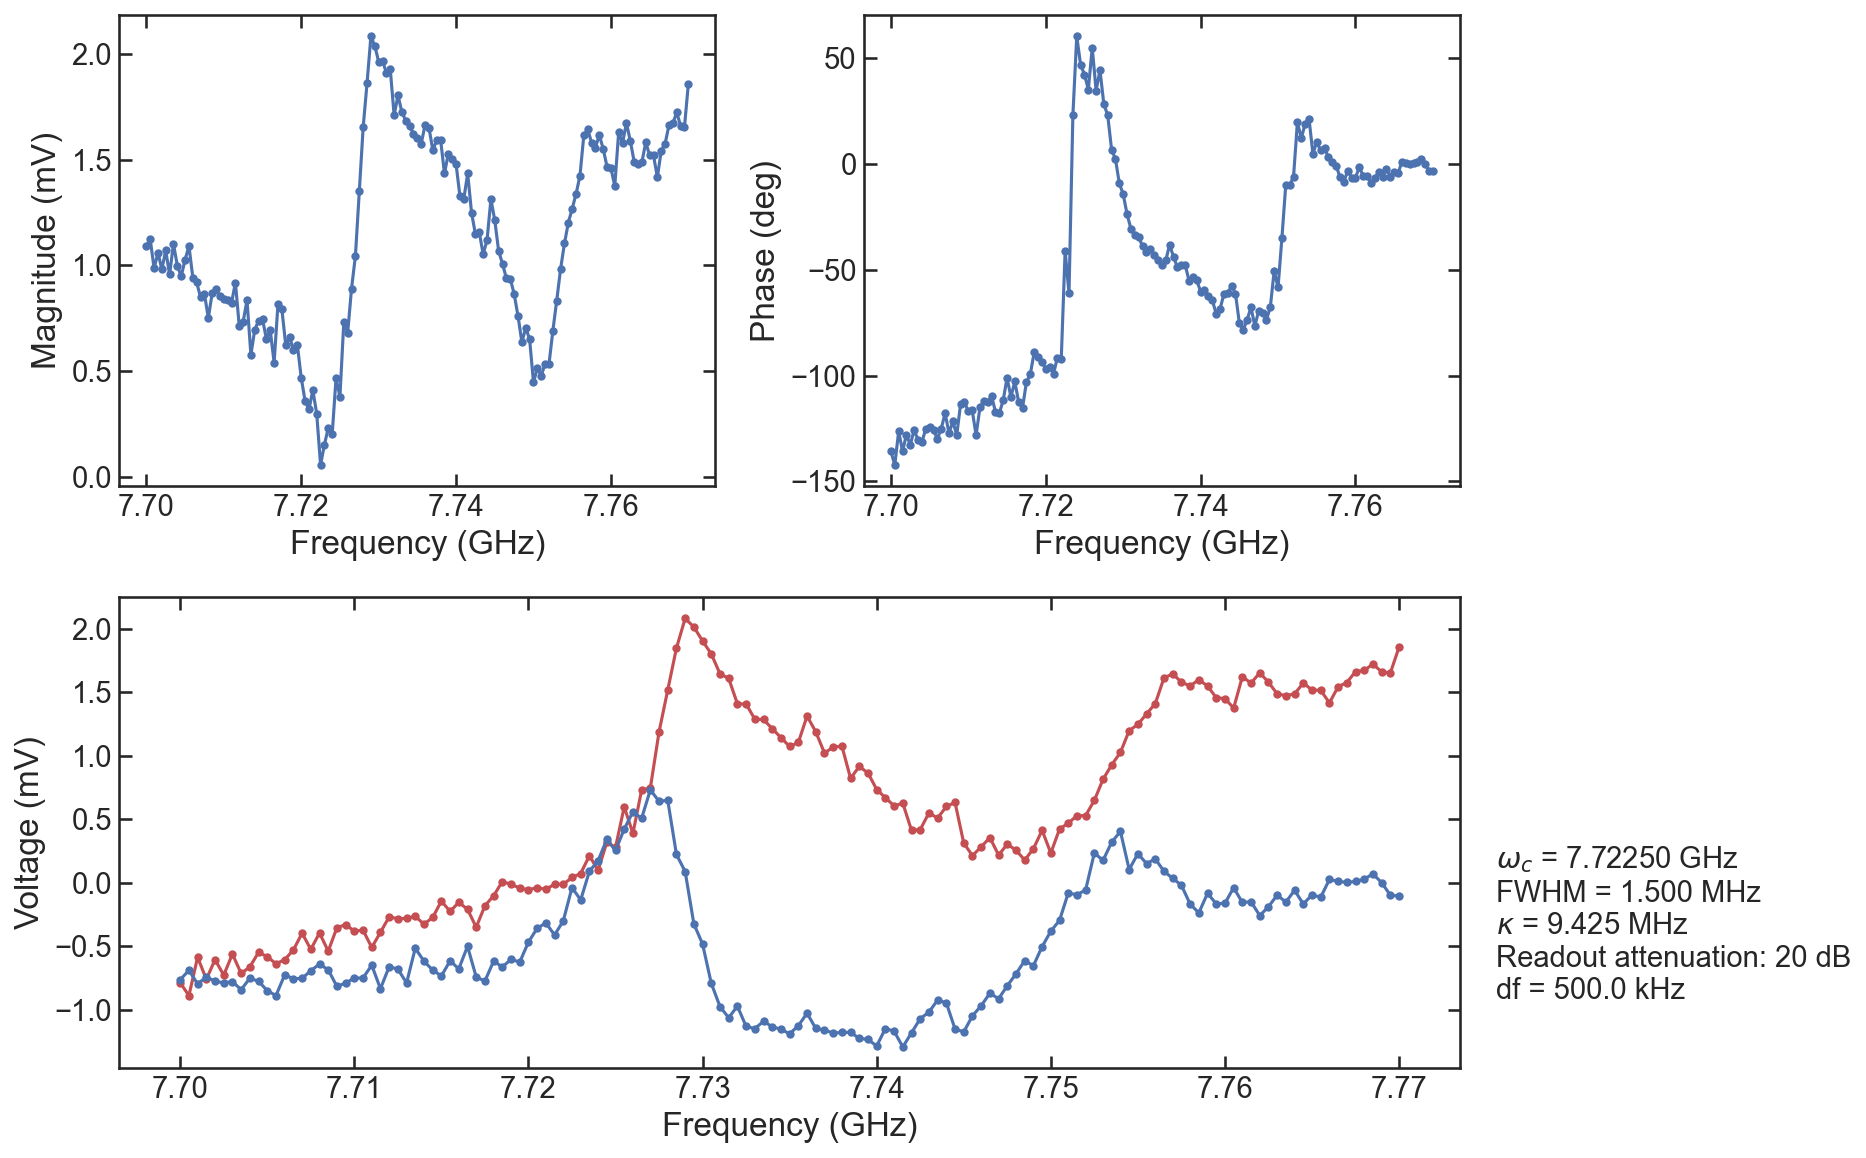

In [48]:
fc,fwhm = pf.fit_res(data['freqs'],data['I'],data['Q'])
pf.resonator_spec_plot(data,qb_pars=qb.pars,fwhm=fwhm,fc=fc)

In [ ]:
from resonator import Resonator

In [ ]:
res = Resonator(port_type='n',f_data=data['freqs'],z_data=data['I']+1j*data['Q'])
res.autofit(electric_delay=50e-9)
res.show()


# Qubit Punchout

**Notes on qubit punchout**

*Objectives*
1. Determine if there is a qubit coupled to a cavity.
2. Determine the readout power at which the qubit is punched out. Used for subsequent measurements.

Starting at low readout power and then gradually decreasing the attenuation, you should see the readout resonance shift in frequency. Since the qubit and readout resonances repel each other, if the qubit frequency is less than the readout frequency, the resonant frequency whill shift to lower frequency after the qubit is punched out, and vice versa. Between the high and low readout power frequencies, the resonator behaves in a non-linear way. We definitely want to operate outside of that region. 

In [ ]:
attenuations = np.arange(0,50,5)
qb.update_value('n_avg',1000)
data, job = qb.punchout(df = 0.75e6,
                #  f_LO = 6.35e9,
                IF_min = 75e6,
                IF_max = 150e6,
                 attenuations=attenuations,
                 savedata=False)

In [ ]:
pf.punchout_plot(data,xlabel='Frequency (GHz)',ylabel='Attenuation (dB)',cbar_label='Magnitude (dBm)')

In [ ]:
qb.update_value('readout_atten',30)

# Qubit Spectroscopy

The first time we run qubit spectroscopy we have to use a high qubit driving amplitude for a couple of reasons. 
1. Detect higher levels like $\omega_{02}/2$ and $\omega_{03}/3$ so you can calculate anharmonicity.
2. Since you don't know exactly what the qubit frequency is going to be (unless you've nailed the fab process), you will have to execute a broad sweep. Driving the qubit at high power broadens the resonance (decreases coherence), makes it easier to detect $\omega_{01}$ -> frequency spacing can be larger.

Due to the negative anharmonicity of the transmon (assuming the device you are working with is a transmon!), the $\omega_{02}/2$ peak is going to have smaller frequency than the $\omega_{01}$ resonance. Keep that in mind when setting up the frequency sweep. 

The *on_off* option of the qubit spectroscopy experiment is there to help distinguish small signals. The off measurement consists of no qubit excitation; just a readout pulse. The on measurement is the regular qubit excitation, followed by readout. The difference between the measurements results is what is saved as our data. The measurement will take almost twice as long, but it might be needed when doing spectroscopy at low powers.

**Some important parameters to setup properly before executing qubit spectroscopy**
1. qubit reset time (qb.pars['resettime']['qubit']): time to wait after performing an ON measurement.
2. amp_q_scaling: explained above
3. 


In [ ]:
amp_q_scaling = 1
qb.update_value('n_avg',1000)
qb.update_value('rr_freq', 6.465e9)
# qb.update_value('rr_IF', 50e6)
qb.update_value('readout_atten',27)
qb.update_value('rr_LO', qb.pars['rr_freq'] - qb.pars['rr_IF'])
qb.pars['resettime']['qubit'] = int(20e3)
qb.write_pars()
qb.experiment = 'qubit_spec'
data, job = qb.qubit_spec(element='qubit',
                                check_mixers=False,
                                IF_min=10e6,
                                IF_max=395e6,
                                f_LO=5.8e9,
                                df=0.5e6,
                                on_off=True,
                                amp_q_scaling = amp_q_scaling,
                                saturation_dur = 20e3,
                                showprogress=True,
                                savedata=False)

In [ ]:
pf.qubit_spec_plot(data,qb_pars=qb.pars,find_peaks=True, amp_q_scaling=amp_q_scaling)

## Run broad spectroscopy scan on qubit

In [ ]:
qb._instruments.set('sa','frequency',6e9)

In [ ]:
qb.update_value('n_avg',5000)
qb.update_value('rr_freq', 6.464e9)
qb.update_value('rr_IF', 50e6)
qb.update_value('rr_LO', qb.pars['rr_freq'] - qb.pars['rr_IF'])
qb.pars['resettime']['qubit'] = int(20e3)
qb.write_pars()
df_qubit_spec = 2e6
data, job = qb.run_scan(df = df_qubit_spec, element='qubit',
                                check_mixers=False,
                                chunksize = 200e6,
                                lo_min = 5e9,
                                lo_max = 6e9,
                                amp_q_scaling = 1,
                                on_off=True,
                                saturation_dur = 20e3,                   
                                showprogress=True,
                                savedata=False)

In [ ]:
pf.qubit_spec_plot(data,qb_pars=qb.pars,df=df_qubit_spec,rrFreq=qb.pars['rr_freq'],amp_q_scaling=1)

In [ ]:
data['freqs']